In [1]:
import efficientnet.keras as efn
from keras.models import Model, model_from_json
from keras.regularizers import l1_l2
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam
import pandas as pd
from keras_preprocessing.image import ImageDataGenerator
from datetime import datetime as dt
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler, TensorBoard
import keras.backend as K
from VCM import VCM 
from keras.initializers import Constant,Orthogonal
from keras import regularizers
from Kappa_Skl import kappa
import keras.backend as K
import matplotlib.pyplot as plt
import itertools
from Homotopy import Homotopy 
from QWK import QWK
import tensorflow as tf
from Fractional_MAXPOOL import FractionalPooling2D

import numpy as np 
import matplotlib.pyplot as plt
import os
import wandb
#from wandb.keras import WandbCallback
#wandb.init(project="rop")


top_layers_checkpoint_path = 'cp.top.best.hdf5'
fine_tuned_checkpoint_path = 'cp.fine_tuned.best.hdf5'
new_extended_inception_weights = 'final_weights.hdf5'





def get_experiment_id():
    time_str = dt.now().strftime('%Y-%m-%d-%H-%M-%S')
    experiment_id = 'base_{}'.format(time_str)
    return experiment_id

#def scheduler(epoch):
#    if epoch == 150:
#        K.set_value(model.optimizer.lr, 0.00003)
#    return K.get_value(model.optimizer.lr)


def create_model():
    base_model = efn.EfficientNetB0(weights=None,
                        include_top=False,
                        input_shape=(128, 128, 3), pooling='avg')
#    base_model._layers.pop()
#    model2 = Model(base_model.input, base_model.layers[-1].output)
##    base_model = InceptionV3(weights=None , include_top=False, input_tensor=None, input_shape=(299, 299, 3), pooling='avg') 
    x = base_model.output
    x = Dense(2, activation="softmax")(x)
    model = Model(inputs = base_model.input, outputs = x)
    model.load_weights('base_2019-12-11-23-01-58-val_kappa_checkpoint.hdf5')
#    model._layers.pop()
#    x = Model(model.input, model.layers[-1].output)
#    model.save_weights("tmp.h5")
#    top_layers_checkpoint_path = 'cp.top.best.hdf5'

#    # first: train only the top layers (which were randomly initialized)
#    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False
#    
#    
#
##    regularizer = l1_l2(l1=0.0005, l2=0.0005)
##    for layer in model.layers:
##        for attr in ['kernel_regularizer', 'bias_regularizer']:
##            if hasattr(layer, attr) and layer.trainable:
##                setattr(layer, attr, regularizer)
#
##
#    out = model_from_json(model.to_json())
#    out.load_weights("tmp.h5", by_name=True)
#
    return model


model = create_model()




radam = Adam(lr=0.0014339, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=1e-6, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=radam, metrics=['mae','acc'])

#sgd = SGD(lr=0.0003, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='mse', optimizer=sgd, metrics=['mae', 'acc'])

experiment_id = get_experiment_id()


train_datagen = ImageDataGenerator(
        rescale=1./255,
#        featurewise_center=True,
 #       samplewise_center=True,
        shear_range=0,
        zoom_range=0.0,#[1 / 1.15, 1.15],
        horizontal_flip=False,#True,
        rotation_range=0)#90,
#        validation_split=0.2)
"""
For the test set only rescale should be made 
"""
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    directory=r"/media/husam/Data/ROP_EXp/binary_class_treatment_noch/train",
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    seed=42)
#    subset="training")
#    save_to_dir="D:/Separating Images into subfolders/train_augmented")


#print(train_generator.class_indices)

valid_generator = valid_datagen.flow_from_directory(
    directory=r"/media/husam/Data/ROP_EXp/binary_class_treatment_noch/vald",
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=10,
    class_mode="categorical",
    shuffle=True,
    seed=42)
#    subset="validation")
#    save_to_dir="D:/Separating Images into subfolders/val_augmented"


test_generator = test_datagen.flow_from_directory(
    directory=r"/media/husam/Data/ROP_EXp/binary_class_treatment_noch/test",
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    seed=42)
#    save_to_dir="D:/Separating Images into subfolders/test_augmented")


# Fitting/Training the model
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
experiment_id = get_experiment_id()


class_weight_list = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
class_weights = dict(zip(np.unique(train_generator.classes), class_weight_list))

callbacks = [
#    Resample_Iterator(balance_weights),
   # QWK(valid_generator, STEP_SIZE_VALID),
    ModelCheckpoint(top_layers_checkpoint_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max'),
#    EarlyStopping(monitor='val_kappa', patience=10, min_delta=0.001, verbose=1, restore_best_weights=True, mode='max',baseline=None),
    VCM(valid_generator, STEP_SIZE_VALID),
#    LearningRateScheduler(scheduler, verbose=1),
 #   TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True),        
]




# train the model on the new data for a few epochs

history1=model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
#                    class_weight=[balance_weights],
                    callbacks=callbacks,
                    epochs=10  
)


 

callbacks1 = [
#    Resample_Iterator(balance_weights1),
    #QWK(valid_generator, STEP_SIZE_VALID),
    ModelCheckpoint(fine_tuned_checkpoint_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_acc', patience=7, min_delta=0.001, verbose=1, restore_best_weights=True, mode='max',baseline=None),
    VCM(valid_generator, STEP_SIZE_VALID),
#    LearningRateScheduler(scheduler, verbose=1),
#    TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True),        
]



for layer in model.layers:
    layer.trainable = True
    
    
    
    
radam = Adam(lr=0.0014339, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=1e-6, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=radam, metrics=['mae','acc'])



# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history=model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
#                    class_weight=[balance_weights1],
                    callbacks=callbacks1,
                    epochs=30) 




test_generator.reset()
#test_imgs, test_labels = next(test_generator)

y_pred = model.predict_generator(test_generator, verbose=1,steps=len(test_generator))

score = model.evaluate_generator(generator=test_generator, verbose=1,steps=len(test_generator))
print('Test loss:', score[0])
print('Test mae:', score[1])
print('Test accuracy:', score[2])

#y_pred =


y_pred = np.argmax(y_pred, axis=1) #multiple categories
# mapping the labels to its classes 
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in y_pred]

y_true = (test_generator.classes)
#confusion Matrix and Classification Report
# generator.classes gives you the truth label y_true
print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)

print(cm)

print('Classification Report')
target_names = ['0', '1']
print(classification_report(y_true, y_pred, target_names=target_names))
                    
                    
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
#plt.savefig('model accuracy.png')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
#plt.savefig('model loss.png')

# summarize history for val_kappa
plt.plot(history.history['val_kappa'])
plt.title('Validation_Kappa')
plt.ylabel('val_kappa')
plt.xlabel('epoch')
plt.legend([ 'validation'], loc='upper left')
plt.show()
#plt.savefig('model validation_kappa.png')

# summarize history for mean_absolute _error
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
#plt.savefig('model maey.png')


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarn

Found 285 images belonging to 2 classes.
Found 23 images belonging to 2 classes.
Found 33 images belonging to 2 classes.
Epoch 1/10
4/4 [==============================] - 3s 869ms/step - loss: 1.7681 - mean_absolute_error: 0.6888 - acc: 0.2601 - val_loss: 1.1139 - val_mean_absolute_error: 0.6006 - val_acc: 0.3500

Epoch 00001: val_acc improved from -inf to 0.35000, saving model to cp.top.best.hdf5
Confusion matrix: 
 [[ 2  1]
 [12  5]]
Epoch 2/10
4/4 [==============================] - 1s 204ms/step - loss: 1.6702 - mean_absolute_error: 0.6766 - acc: 0.2529 - val_loss: 0.8978 - val_mean_absolute_error: 0.5509 - val_acc: 0.3077

Epoch 00002: val_acc did not improve from 0.35000
Confusion matrix: 
 [[1 1]
 [9 2]]
Epoch 3/10
4/4 [==============================] - 1s 125ms/step - loss: 1.6442 - mean_absolute_error: 0.6864 - acc: 0.2564 - val_loss: 1.0052 - val_mean_absolute_error: 0.5851 - val_acc: 0.3846

Epoch 00003: val_acc improved from 0.35000 to 0.38462, saving model to cp.top.best.hd

4/4 [==============================] - 1s 309ms/step - loss: 0.3014 - mean_absolute_error: 0.2342 - acc: 0.9180 - val_loss: 0.1990 - val_mean_absolute_error: 0.1725 - val_acc: 1.0000

Epoch 00018: val_acc improved from 0.92308 to 1.00000, saving model to cp.fine_tuned.best.hdf5
Confusion matrix: 
 [[ 3  1]
 [ 0 16]]
Epoch 19/30
4/4 [==============================] - 1s 235ms/step - loss: 0.2580 - mean_absolute_error: 0.2046 - acc: 0.9509 - val_loss: 0.2956 - val_mean_absolute_error: 0.2324 - val_acc: 0.9500

Epoch 00019: val_acc did not improve from 1.00000
Confusion matrix: 
 [[4 1]
 [0 8]]
Epoch 20/30
4/4 [==============================] - 1s 347ms/step - loss: 0.2369 - mean_absolute_error: 0.1929 - acc: 0.9492 - val_loss: 0.1749 - val_mean_absolute_error: 0.1540 - val_acc: 1.0000

Epoch 00020: val_acc did not improve from 1.00000
Confusion matrix: 
 [[ 2  1]
 [ 0 10]]
Epoch 21/30
4/4 [==============================] - 1s 265ms/step - loss: 0.2172 - mean_absolute_error: 0.1794 - acc:

NameError: name 'confusion_matrix' is not defined

In [2]:
from sklearn.metrics import confusion_matrix, classification_report

test_generator.reset()
#test_imgs, test_labels = next(test_generator)

y_pred = model.predict_generator(test_generator, verbose=1,steps=len(test_generator))

score = model.evaluate_generator(generator=test_generator, verbose=1,steps=len(test_generator))
print('Test loss:', score[0])
print('Test mae:', score[1])
print('Test accuracy:', score[2])


y_pred = np.argmax(y_pred, axis=1) #multiple categories
# mapping the labels to its classes 
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in y_pred]

y_true = (test_generator.classes)
#confusion Matrix and Classification Report
# generator.classes gives you the truth label y_true
print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)

print(cm)

print('Classification Report')
target_names = ['0', '1']
print(classification_report(y_true, y_pred, target_names=target_names))

33/33 [==============================] - 0s 10ms/step
Test loss: 0.6858368180692196
Test mae: 0.4248692420395938
Test accuracy: 0.6060606060606061
Confusion Matrix
[[ 1 11]
 [ 2 19]]
Classification Report
              precision    recall  f1-score   support

           0       0.33      0.08      0.13        12
           1       0.63      0.90      0.75        21

    accuracy                           0.61        33
   macro avg       0.48      0.49      0.44        33
weighted avg       0.52      0.61      0.52        33



In [3]:
def kappa2(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:
        y_true = y_true.dot(range(y_true.shape[1]))
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = y_pred.dot(range(y_pred.shape[1]))
    try:
        return kappa(y_true, y_pred, weights='quadratic')
    except IndexError:
        return np.nan
    
print('Quadratic_wieghted_kappa')
print(kappa2(y_true, y_pred))

Quadratic_wieghted_kappa
-0.014184397163120366


dict_keys(['val_loss', 'val_mean_absolute_error', 'val_acc', 'loss', 'mean_absolute_error', 'acc'])


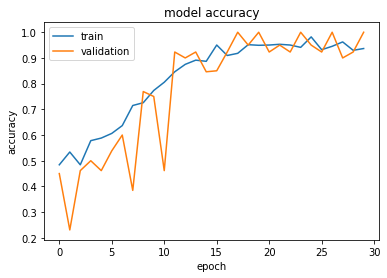

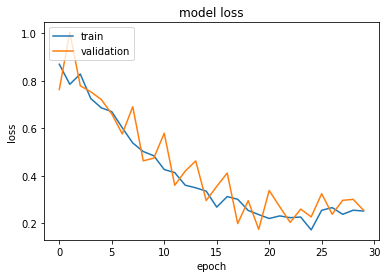

KeyError: 'val_kappa'

In [4]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
#plt.savefig('model accuracy.png')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
#plt.savefig('model loss.png')

# summarize history for val_kappa
plt.plot(history.history['val_kappa'])
plt.title('Validation_Kappa')
plt.ylabel('val_kappa')
plt.xlabel('epoch')
plt.legend([ 'validation'], loc='upper left')
plt.show()
#plt.savefig('model validation_kappa.png')

# summarize history for mean_absolute _error
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
#plt.savefig('model maey.png')